In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 8ff5168a95dd65692e4a491d0183643e4b94d410
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [98]:
from MI_prediction.Utils.Datasets import DataLoader, DataLoader_Rest, get_epochs, get_runs
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler

# Lawhern2018 sklearn

## BCI2a

### Load data

In [160]:
dl = DataLoader(dataset_name="BNCI2014001")
dl.load_data(subject_ids=[3])

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]


In [161]:
low_cut_hz = 4.
high_cut_hz = 38.
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
            Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
            Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
            Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
            Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                        factor_new=factor_new, init_block_size=init_block_size)
        ]

dl.preprocess_data(preprocessors=preprocessors)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 sample

In [162]:
trials = dl.get_trials(start_offset=[0], end_offset=[0])

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching even

In [163]:
X,y = get_epochs(trials['win_0'].split('session')['session_T'])

In [164]:
idx_2class = (y==0)+(y==1)
X2 = X[idx_2class,:,:]
y2 = y[idx_2class]

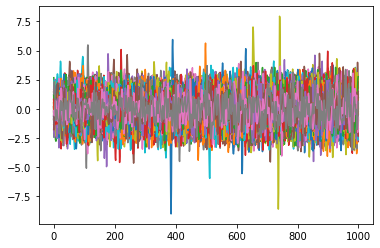

In [165]:
plt.plot(X[:,0,:].T)
plt.show()

### CSP + LDA

In [166]:
preds = []
y_true = []
acc = []
c = 0
seed = 1234

skf = StratifiedKFold(n_splits=4)

lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)
scaler = StandardScaler()
clf = Pipeline([('CSP', csp), ('Scaler',scaler),('LDA', lda)])

scores = cross_val_score(clf, X2.astype('float'), y2, cv=skf, n_jobs=-1,verbose=1)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 4.8 (2.2e-16 eps * 22 dim * 9.9e+14  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
    Using tolerance 4.9 (2.2e-16 eps * 22 dim * 1e+15  max singular value)
    Using tolerance 4.9 (2.2e-16 eps * 22 dim * 1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
    Using tolerance 4.9 (2.2e-16 eps * 22 dim * 1e+15  max singular value)
Reducing data rank from 22 -> 22
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Estimating covariance using EMPIRICAL
Reducing data rank from 22 -> 22
Done.
Estimating covariance using EMPIRICAL
Done.
Redu

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


In [167]:
scores

array([0.94444444, 0.94444444, 0.91666667, 0.88888889])

In [168]:
np.mean(scores)

0.923611111111111